<a href="https://colab.research.google.com/github/JontySinai/ProbabilisticProgramming/blob/master/my_BayesianMethodsForHackers/2_ChallengerShuttle.ipynb">
  <img style="float: left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Bayesian Methods for Hackers
## Challenger Shuttle 
**Chapter 02 - More PyMC3/TFP**<br>

**Source:** https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/tree/master/Chapter2_MorePyMC

In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !pip3 install -q wget
    import wget

In [2]:
import os
import typing

from typing import Dict, List, Tuple

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

from IPython.core.pylabtools import figsize

import numpy as np
import pandas as pd
import scipy.stats as stats

import pymc3 as pm
import theano.tensor as tt

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

np.random.seed(1901)

def session_options(enable_gpu_ram_resizing=True, enable_xla=False):
    """
    Allowing the notebook to make use of GPUs if they're available.

    XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear
    algebra that optimizes TensorFlow computations.
    """
    config = tf.config
    gpu_devices = config.experimental.list_physical_devices('GPU')
    if enable_gpu_ram_resizing:
        for device in gpu_devices:
            tf.config.experimental.set_memory_growth(device, True)
    if enable_xla:
        config.optimizer.set_jit(True)
    return config

session_options(enable_gpu_ram_resizing=True, enable_xla=True)

<module 'tensorflow_core._api.v2.config' from '/Users/jontysinai/anaconda3/envs/axiom/lib/python3.7/site-packages/tensorflow_core/_api/v2/config/__init__.py'>

### Challenger Data

Here we will be dealing with a categorical dataset. The _Challenger Shuttle Disaster_ on 28 January 1986 was concluded to have been caused by an O-ring failure in one of the shuttle's rocket boosters, causing the O-ring to become highly sensitive to temperature. Data is availble for previous 23 (out of 24) flights for which there was an O-ring data due to outside temperature. It was concluded that there was no indicative trend that the failures were caused by temperature, but let's see what we can find.  

In [3]:
if IN_COLAB:
    print('Fetching data from Github ...')
    url = 'https://raw.githubusercontent.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/master/Chapter2_MorePyMC/data/challenger_data.csv'
    _data = wget.download(url, )
    filepath = "txtdata.csv"
else:
    filepath = os.path.join("data", "challenger_data.csv")

challenger_data = np.genfromtxt("data/challenger_data.csv", 
                                skip_header=1,
                                usecols=[1, 2], 
                                missing_values="NA",
                                delimiter=",")
#drop NA values, leaving us with failure Yes/No data
challenger_data = challenger_data[~np.isnan(challenger_data[:, 1])]
n_challenger_data = len(challenger_data)

print(f'Number of test flights: {n_challenger_data}')

Number of test flights: 23


#### Representing categorical data

The response variable (failure or not) is discretely represented as $1 \text{ (failure)}$ or $0 \text{ (no failure)}$. The first variable represents temperature.

In [4]:
challenger_data

array([[66.,  0.],
       [70.,  1.],
       [69.,  0.],
       [68.,  0.],
       [67.,  0.],
       [72.,  0.],
       [73.,  0.],
       [70.,  0.],
       [57.,  1.],
       [63.,  1.],
       [70.,  1.],
       [78.,  0.],
       [67.,  0.],
       [53.,  1.],
       [67.,  0.],
       [75.,  0.],
       [70.,  0.],
       [81.,  0.],
       [76.,  0.],
       [79.,  0.],
       [75.,  1.],
       [76.,  0.],
       [58.,  1.]])

We can visualise these discrete points using a scatterplot. Also take note just _how little data_ we actually have.

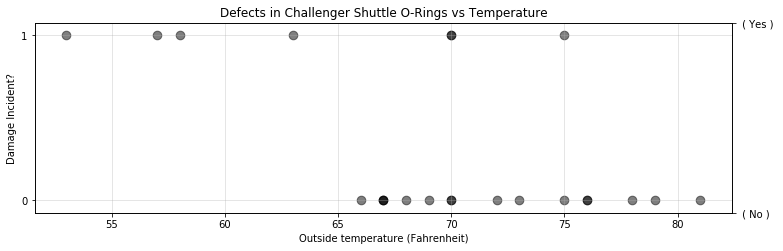

In [5]:
fig, axs = plt.subplots(1, 1, figsize=(12.5, 3.5))

axs.scatter(challenger_data[:, 0], challenger_data[:, 1], s=75, color="black", alpha=0.5)
axs.set_yticks([0, 1])
axs.set_ylabel("Damage Incident?")
axs.set_xlabel("Outside temperature (Fahrenheit)")
axs.set_title("Defects in Challenger Shuttle O-Rings vs Temperature")

key_axs = axs.twinx()
key_axs.set_yticks([0, 1])
key_axs.set_yticklabels([' ( No ) ', ' ( Yes ) '])

axs.grid(alpha=0.4);

How do we model probabilities over a binary caterogical response variable? We use a special type of continuous function, which asymptotically maps 

$$\mathbb{R} \to \{0, 1\}.$$

The function which we use is known as the _logistic function_ (a.k.a. the _sigmoid function_ ):

$$ p(t) = \frac{1}{1 + e^{t}}. $$

As we can see from the plot, the shape of the logistic function is fit for purpose:

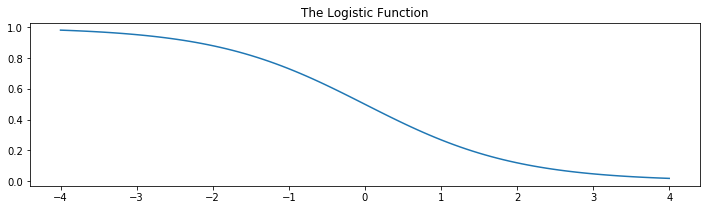

In [6]:
figsize(12, 3)

t = np.linspace(-4, 4, 100)
p_t = 1.0 / (1.0 + np.exp(t)) 
plt.plot(t, p_t)
plt.title('The Logistic Function');

We can control the shape of the logistic function by adding a parameter vector, $\beta$, which weights the inputs $t$:

$$ p(\; t \;| \; \beta \;) = \frac{1}{1 + e^{\beta t}}. $$

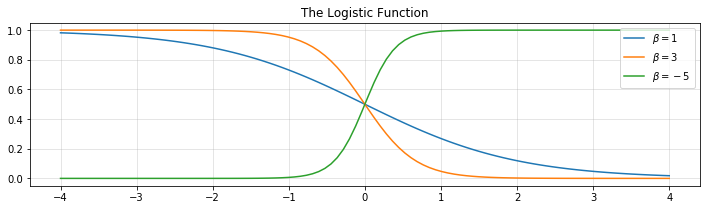

In [7]:
def logistic(x, beta):
    return 1.0 / (1.0 + np.exp(beta * x))

figsize(12, 3)

t = np.linspace(-4, 4, 100)
plt.plot(t, logistic(t, 1), label=r"$\beta = 1$")
plt.plot(t, logistic(t, 3), label=r"$\beta = 3$")
plt.plot(t, logistic(t, -5), label=r"$\beta = -5$")
plt.title('The Logistic Function')
plt.legend(loc='upper right')
plt.grid(alpha=0.4);

Finally we can shift the _inflection point_ (the point at which the probability switches) by adding a so called _bias term_, $\alpha$:

$$ p(\; t \;| \; \beta, \; \alpha \;) = \frac{1}{1 + e^{\alpha + \beta t}}. $$

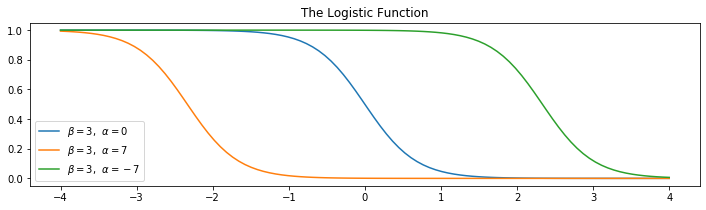

In [8]:
def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

t = np.linspace(-4, 4, 100)

plt.plot(t, logistic(t, 3, alpha=0), label=r"$\beta = 3$,  $\alpha = 0$")
plt.plot(t, logistic(t, 3, alpha=7), label=r"$\beta = 3$,  $\alpha = 7$")
plt.plot(t, logistic(t, 3, alpha=-7), label=r"$\beta = 3$,  $\alpha = -7$")

plt.title('The Logistic Function')
plt.legend(loc="lower left");

As always in Bayesian modelling, we are now interested in finding the optimal paramters $\theta=(\alpha, \beta)$, which best fit the data. 

Since there is no reason for the $\alpha$ or $\beta$ to be constrained in $\mathbb{R}$, we will use a _normal distribution_ as priors for both.

>Note: in the original Bayesian Methods for Hackers version, the author chooses to parametrise the normal distribution by the _precision parameter_ (the inverse of variance) for historical reasons. This parameter is less easy to interpret and for the sake of consistency with our intuition, I will use varaince instead.

The _normal distribution_ itself is parametrised by its _mean_ , $\mu$, and _variance_ , $\sigma^{2}$, which are more generically referred to as _location_ and _scale_:

$$X \sim \mathscr{N}(\; \mu \;, \; \sigma^{2} \;).$$

Since we like normal distributions, let's plot a few.

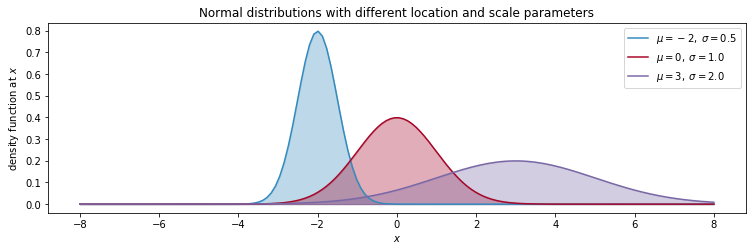

In [9]:
figsize(12.5, 3.5)

x = np.linspace(-8, 8, 150)

mu = (-2, 0, 3)
sigma = (.5, 1, 2)
colors = ["#348ABD", "#A60628", "#7A68A6"]

for mu_, sigma_, color in zip(mu, sigma, colors):
    p = stats.norm.pdf(x, mu_, scale=sigma_)
    
    plt.plot(x, p, label=f"$\mu = {mu_},\;\\sigma = {sigma_:.1f}$", color=color)
    plt.fill_between(x, p, color=color, alpha=.33)

plt.legend(loc="upper right")
plt.xlabel("$x$")
plt.ylabel("density function at $x$")
plt.title("Normal distributions with different location and scale parameters");

## Mathematical Model

So we will assume that both $\alpha$ and $\beta$ are distributed by the following normal:

$$\alpha, \beta \sim \mathscr{N}(\; 0\;, 1000\; ).$$

Then we will model the the probability of a defect, $D$, given temperature, $t$ by:

$$p(t) = P(\; D \;|\; t;\theta\;) = \frac{1}{1 + e^{\alpha + \beta t}}.$$

But let's be careful here. The _probability of a defect_ is a **different** quantity to the _observation of a defect_. One is a continuous number between $0$ and $1$, and the latter is the _random variable_ itself which takes discrete values $0$ or $1$. In Bayesian modelling, we need a distribution to describe the random vairable. An appropriate distribution which we can use here is the $Bernoulli$ distribution, using the precompute logistic probabilities. Specifically:

$$ D_i \sim Bern(\; p(t_i) \;), \text{ for each } i. $$

> Note that what we have done is specify a joint normal prior for $\theta$ and a Bernoulli likelihood for the categorical response variable.

# PyMC3 Model

In [10]:
temperature = challenger_data[:, 0]
D = challenger_data[:, 1]  # defect or not?

with pm.Model() as model:
    beta = pm.Normal("beta", mu=0, sigma=1000, testval=0)
    alpha = pm.Normal("alpha", mu=0, sigma=1000, testval=0)
    
    logistic_tt = lambda t: 1.0 / (1. + tt.exp(beta * t + alpha))
    
    p = pm.Deterministic("p", logistic_tt(temperature))

We will use the $Bernoulli$ distribution, as defined above, and the observed data to optimize the parameters in the posterior:

$$ P(\; \theta \;|\; D, t\;).$$

In [11]:
%%time

# connect the probabilities in `p` with our observations through a
# Bernoulli random variable.
with model:
    observed = pm.Bernoulli("bernoulli_obs", p, observed=D)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(120000, step=step, start=start)
    burned_trace = trace[100000::2]

logp = -25.827, ||grad|| = 11.913: 100%|██████████| 27/27 [00:00<00:00, 1361.98it/s]  
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta]
Sampling 2 chains, 0 divergences: 100%|██████████| 241000/241000 [01:18<00:00, 3081.75draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


CPU times: user 1min 26s, sys: 7.02 s, total: 1min 33s
Wall time: 1min 51s


Now we can use the samples from the burned trace to visualise the posterior distribution of the parameters.

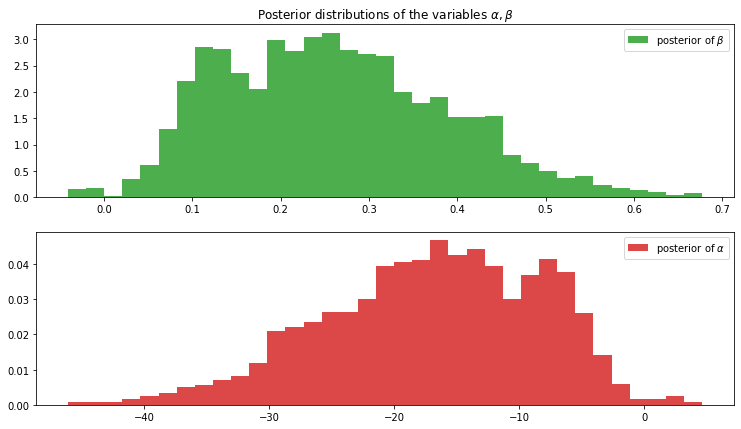

In [12]:
alpha_samples = burned_trace["alpha"].reshape(-1, 1)
beta_samples = burned_trace["beta"].reshape(-1, 1)

fig, axs = plt.subplots(2, 1, figsize=(12.5, 7))

axs[0].hist(beta_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\beta$", color="tab:green", density=True)
axs[0].legend()

axs[1].hist(alpha_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\alpha$", color="tab:red", density=True)
axs[1].legend()

axs[0].set_title(r"Posterior distributions of the variables $\alpha, \beta$");

> The fact that the posterior density of $\beta$ is not centered around zero does, indeed, tell us that temperature has an effect on a defect happening.

Now how do we use these posteriors to interpret the correct logistic function? It looks as if the spread in both distributions is fairly wide.

Since we are using Bayesian inference, we can use the expected value for both and report a confidence interval (_credible set_ ) showing our uncertainty in the true parameters:

#### Take samples of logistic functions from the posterior distribution:

In [13]:
def logistic(x, beta=1, alpha=0):
    return 1. / (1. + np.exp( alpha + beta * x ))

In [14]:
n_samples_to_plot = 150

t = np.linspace(temperature.min() - 5, temperature.max()+5, 50)[:, None]
posterior_logistic_functions = logistic(t.T, beta_samples, alpha_samples)

# posterior mean
mean_logistic_function = posterior_logistic_functions.mean(axis=0)

# some posterior samples
plot_these = np.random.choice(np.arange(posterior_logistic_functions.shape[0]), n_samples_to_plot)
sampled_logistic_functions = np.take(posterior_logistic_functions, indices=plot_these, axis=0)

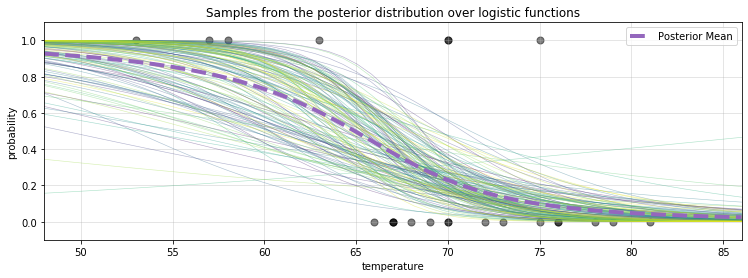

In [15]:
figsize(12.5, 4)
viridis = cm.get_cmap('viridis', n_samples_to_plot)
viridis = viridis(np.linspace(0, 1, n_samples_to_plot))

for l_fn, hue in zip(sampled_logistic_functions, viridis):
    plt.plot(t, l_fn, lw=0.6, color=hue, alpha=0.4)

plt.plot(t, mean_logistic_function, lw=4, ls='--', color='tab:purple', label='Posterior Mean')
plt.scatter(temperature, D, color="k", s=50, alpha=0.5)

plt.title("Samples from the posterior distribution over logistic functions")
plt.legend(loc="upper right")
plt.ylim(-0.1, 1.1)
plt.xlim(t.min(), t.max())
plt.ylabel("probability")
plt.xlabel("temperature")
plt.grid(alpha=0.4);

We can see that some of these logistic functions (the upward slanted diagonal lines) are low probability samples from the tails of the joint posterior, so a more helpful set of samples is the _credible interval_ which we just approximate with a 95% confidence interval:

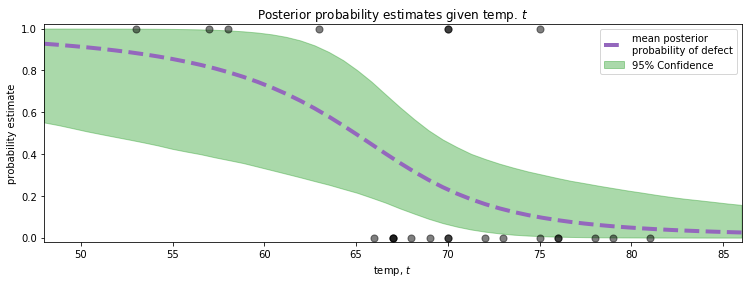

In [16]:
# mstats: statistical functions for masked arrays
from scipy.stats.mstats import mquantiles

figsize(12.5, 4)

# 95% confidence interval taken between 0.025 and 0.975 percentiles
lower, upper = mquantiles(posterior_logistic_functions, [0.025, 0.975], axis=0)
plt.fill_between(t[:, 0], lower, upper, alpha=0.4, color="tab:green", label='95% Confidence')

plt.plot(t, mean_logistic_function, lw=4, ls="--", color="tab:purple",
         label="mean posterior \nprobability of defect")

plt.xlim(t.min(), t.max())
plt.ylim(-0.02, 1.02)
plt.legend(loc="upper right")
plt.scatter(temperature, D, color="k", s=50, alpha=0.5)
plt.xlabel("temp, $t$")

plt.ylabel("probability estimate")
plt.title("Posterior probability estimates given temp. $t$");

We have some wide uncertainty for lower temperatures (possibly pointing at other causes), but as the temperature increases, the uncertainty tightens: we can be sure that temperatures have a strong role to play in defects.

# TFP Model

We will now repeat the same using `tensorflow-probability`

In [17]:
matplotlib_style = 'fivethirtyeight'
plt.style.use(matplotlib_style)

We will be executing eagerly:

In [18]:
tf.executing_eagerly()

True

We will use the following evaluate function to retrieve numpy arrays from tensors:

In [19]:
def evaluate(tensors):
    """Evaluates Tensor or EagerTensor to Numpy `ndarray`s.
    Args:
    tensors: Object of `Tensor` or EagerTensor`s; can be `list`, `tuple`,
        `namedtuple` or combinations thereof.

    Returns:
        ndarrays: Object with same structure as `tensors` except with `Tensor` or
          `EagerTensor`s replaced by Numpy `ndarray`s.
    """
    if tf.executing_eagerly():
        return tf.nest.pack_sequence_as(
            tensors,
            [t.numpy() if tf.is_tensor(t) else t for t in tf.nest.flatten(tensors)])
    return sess.run(tensors)

## Challenger Data in TF

Since by convention the numpy arrays will have a "_" suffix, let's make a copy of the challenger data we downloaded and then create the tensor versions from that

In [20]:
challenger_data_ = challenger_data.copy()

print(challenger_data_)

temperature_ = challenger_data_[:, 0]
temperature = tf.convert_to_tensor(temperature_, dtype=tf.float32)

D_ = challenger_data_[:, 1]
D = tf.convert_to_tensor(D_, dtype=tf.float32)

[[66.  0.]
 [70.  1.]
 [69.  0.]
 [68.  0.]
 [67.  0.]
 [72.  0.]
 [73.  0.]
 [70.  0.]
 [57.  1.]
 [63.  1.]
 [70.  1.]
 [78.  0.]
 [67.  0.]
 [53.  1.]
 [67.  0.]
 [75.  0.]
 [70.  0.]
 [81.  0.]
 [76.  0.]
 [79.  0.]
 [75.  1.]
 [76.  0.]
 [58.  1.]]


## Logistic Model in TFP

Now we define the `joint_log_prob` model using the normal priors, logistic function deterministic mapping and the Bernoulli likelihood:

In [21]:
def challenger_joint_log_prob(temperature_, D, alpha, beta):
    """
    Joint log probability optimization function.
        
    Args:
      temperature_: Temperature on the days of the observation of the presence or absence of a defect
      D: Binary categorical response variable representing defect or not
      alpha: bias parameter of the logitistic probabilities - to be optimized by HMC
      beta: weight parameter of the logitistic probabilities - to be optimized by HMC
    Returns: 
      Joint log probability optimization function.
    """
    rv_alpha = tfd.Normal(loc=0., scale=1000.)
    rv_beta = tfd.Normal(loc=0., scale=1000.)

    # make this into a logit
    logistic_p = 1. / (1. + tf.exp(beta * tf.cast(temperature_, dtype=tf.float32) + alpha))
    rv_observed = tfd.Bernoulli(probs=logistic_p)
    
    return (
        rv_alpha.log_prob(alpha)
        + rv_beta.log_prob(beta)
        + tf.reduce_sum(rv_observed.log_prob(D))
    )

Next we need to define a _closure_ over the `joint_log_prob` function, which fixes the arguments which are not to be optimized by HMC. This is because the TFP implementation of HMC will try to optimize every argument of the `joint_log_prob` function.

In [22]:
# *args will be optimized (in this case: alpha, beta)
unnormalized_posterior_log_prob = lambda *args: challenger_joint_log_prob(temperature_, D, *args)

### TFP MCMC Sampler

In [23]:
# wrap the mcmc sampling call in a @tf.function to speed it up
@tf.function(autograph=False)
def graph_sample_chain(*args, **kwargs):
    return tfp.mcmc.sample_chain(*args, **kwargs)

Now let's initialise the parameter variables (this is TensorFlow after all) as a vector of all zeros.

In [24]:
initial_chain_state = [
    0. * tf.ones([], dtype=tf.float32, name="init_alpha"),
    0. * tf.ones([], dtype=tf.float32, name="init_beta")
]

And again we need to define unconstraining bijectors which map parameter space to $\mathbb{R}$ where HMC will operate:

In [25]:
unconstraining_bijectors = [
    tfp.bijectors.Identity(),      # alpha bijector
    tfp.bijectors.Identity()           # beta bijector
]

We will be using an adapative step-size, which will be modified. Let's initialise that as well as other sampling parameters:

In [26]:
num_burnin_steps = 5000
num_results = 10000
step_size = 0.01

Now let's define the HMC Sampler

In [27]:
# we need the TransformedTransitionKernel in order to apply the unconstraining bijectors the HMC samplers
hmc_kernel=tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        num_leapfrog_steps=40,  # apparently we need such a high num of leapfrog steps for convergence
        step_size=step_size,
        state_gradients_are_stopped=True),
    bijector=unconstraining_bijectors)

# outer kernel which will adapt the stepsize of the HMC sampler
hmc_with_adaptive_step_size = tfp.mcmc.SimpleStepSizeAdaptation(
    inner_kernel=hmc_kernel, num_adaptation_steps=int(num_burnin_steps * 0.8))

Now finally let's sample from this Markov Chain

In [28]:
%%time

# Sampling from the chain.
[
    posterior_alpha,
    posterior_beta
], kernel_results = graph_sample_chain(
        kernel=hmc_with_adaptive_step_size,
        current_state=initial_chain_state,
        num_results = num_results,
        num_burnin_steps = num_burnin_steps)

/Users/jontysinai/.local/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:333: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


CPU times: user 1min 52s, sys: 7.41 s, total: 2min
Wall time: 1min 33s


In [29]:
[
    posterior_alpha_,
    posterior_beta_,
    kernel_results_
] = evaluate([
    posterior_alpha,
    posterior_beta,
    kernel_results
])

In [30]:
print("acceptance rate: {}".format(
    kernel_results_.inner_results.inner_results.is_accepted.mean()))
print("final step size: {}".format(
    kernel_results_.inner_results.inner_results.accepted_results.step_size[-100:].mean()))

acceptance rate: 0.765
final step size: 0.012201900593936443


Now we will use the evaluated tensors to plot the posterior distributions

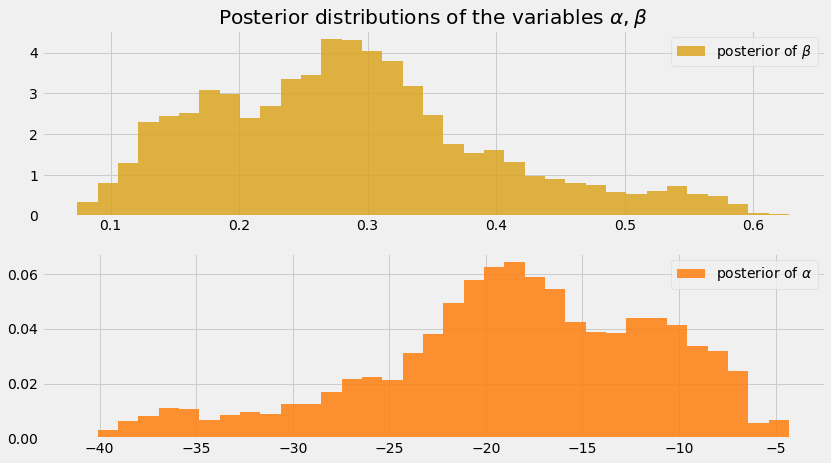

In [31]:
fig, axs = plt.subplots(2, 1, figsize=(12.5, 7))

axs[0].hist(posterior_beta_, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\beta$", color="goldenrod", density=True)
axs[0].legend()

axs[1].hist(posterior_alpha_, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"posterior of $\alpha$", color="tab:orange", density=True)
axs[1].legend()

axs[0].set_title(r"Posterior distributions of the variables $\alpha, \beta$");

And now let's visualize some samples from the logistic posterior

In [32]:
def logistic_tf(x, beta=1., alpha=0.):
    return 1. / (1. + tf.exp( alpha + beta * x ))

In [33]:
n_samples_to_plot = 150

beta_samples_ = posterior_beta_.reshape(-1, 1)
alpha_samples_ = posterior_alpha_.reshape(-1, 1)

t = np.linspace(temperature_.min() - 5, temperature_.max()+5, 50)[:, None]
posterior_logistic_functions = logistic_tf(t.T, beta_samples_, alpha_samples_)

[
    posterior_logistic_functions_
] = evaluate([
    posterior_logistic_functions
])

# posterior mean
mean_logistic_function_ = posterior_logistic_functions_.mean(axis=0)

# some posterior samples
plot_these = np.random.choice(np.arange(posterior_logistic_functions_.shape[0]), n_samples_to_plot)
sampled_logistic_functions_ = np.take(posterior_logistic_functions_, indices=plot_these, axis=0)

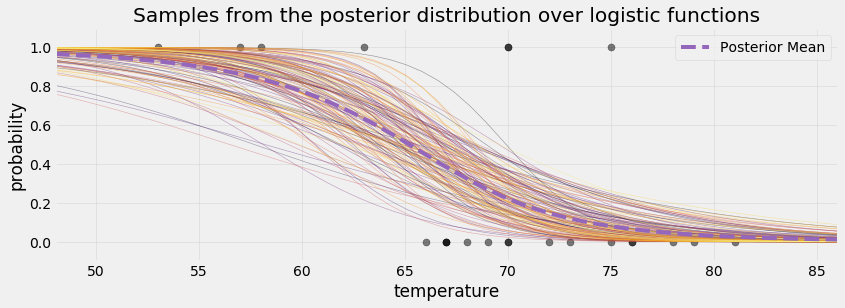

In [34]:
figsize(12.5, 4)
inferno = cm.get_cmap('inferno', n_samples_to_plot)
inferno = inferno(np.linspace(0, 1, n_samples_to_plot))

for l_fn, hue in zip(sampled_logistic_functions_, inferno):
    plt.plot(t, l_fn, lw=0.6, color=hue, alpha=0.4)

plt.plot(t, mean_logistic_function_, lw=4, ls='--', color='tab:purple', label='Posterior Mean')
plt.scatter(temperature_, D_, color="k", s=50, alpha=0.5)

plt.title("Samples from the posterior distribution over logistic functions")
plt.legend(loc="upper right")
plt.ylim(-0.1, 1.1)
plt.xlim(t.min(), t.max())
plt.ylabel("probability")
plt.xlabel("temperature")
plt.grid(alpha=0.4);

And finally let's plot a confidence interval over our logistic posterior mean

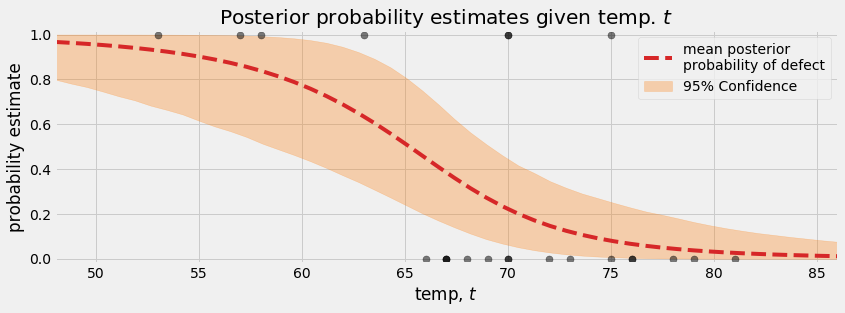

In [35]:
# mstats: statistical functions for masked arrays
from scipy.stats.mstats import mquantiles

figsize(12.5, 4)

# 95% confidence interval taken between 0.025 and 0.975 percentiles
lower_, upper_ = mquantiles(posterior_logistic_functions_, [0.025, 0.975], axis=0)
plt.fill_between(t[:, 0], lower_, upper_, alpha=0.3, color="tab:orange", label='95% Confidence')

plt.plot(t, mean_logistic_function_, lw=4, ls="--", color="tab:red",
         label="mean posterior \nprobability of defect")

plt.xlim(t.min(), t.max())
plt.ylim(-0.02, 1.02)
plt.legend(loc="upper right")
plt.scatter(temperature, D, color="k", s=50, alpha=0.5)
plt.xlabel("temp, $t$")

plt.ylabel("probability estimate")
plt.title("Posterior probability estimates given temp. $t$");